## ДЗ Модели ARIMA и GARCH

- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

In [26]:
import pandas as pd
import numpy as np
import tqdm

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt


from scipy.stats import boxcox
from math import sqrt

from arch import arch_model

import warnings
warnings.filterwarnings("ignore") 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def test_stationarity(timeseries, s = 0):
    
    dftest = adfuller(timeseries, autolag='AIC')
    if s == 0:
        print('Results of Dickey-Fuller Test:')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
        for [key, value] in dftest[4].items():
            dfoutput['Critical Value (%s)' % key] = value
        print(dfoutput)
    return dftest[1]

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [5]:
series = pd.read_csv("data/TimeSeries/monthly-sales-of-company-x-jan-6.csv")["Count"].values.astype('float64')

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


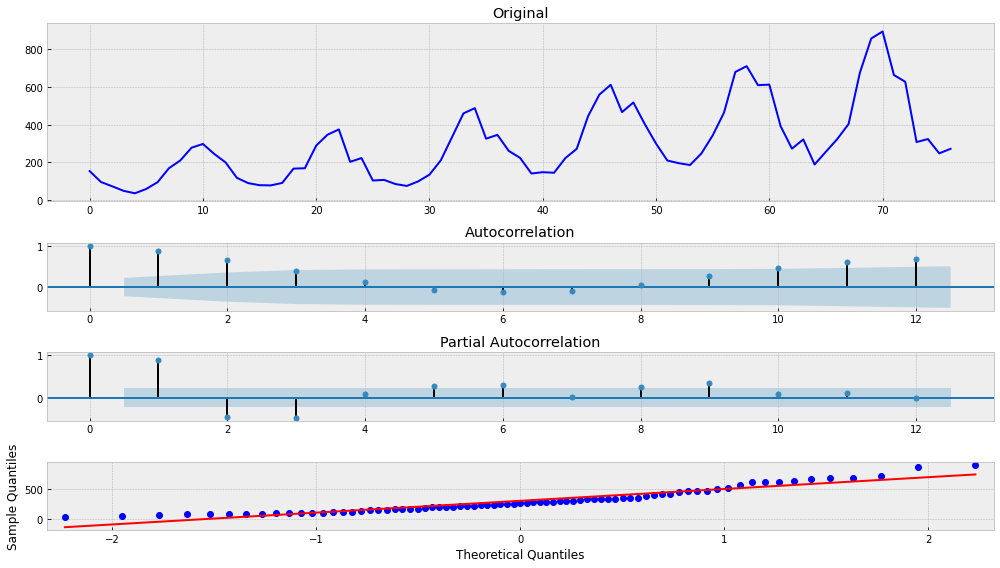

In [6]:
tsplot(series, lags=12)

QQplot показывает что остатки имеют нектороую ависимость и автокоррелграмма тоже говорит о том что есть зависимость от предыдущих значений. Вручную продифференцируем дважды, убеерм сезонность и тренд, что бы проверить стационарность ряда:

Results of Dickey-Fuller Test:
Test Statistic                 -5.290390
p-value                         0.000006
#Lags Used                      9.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


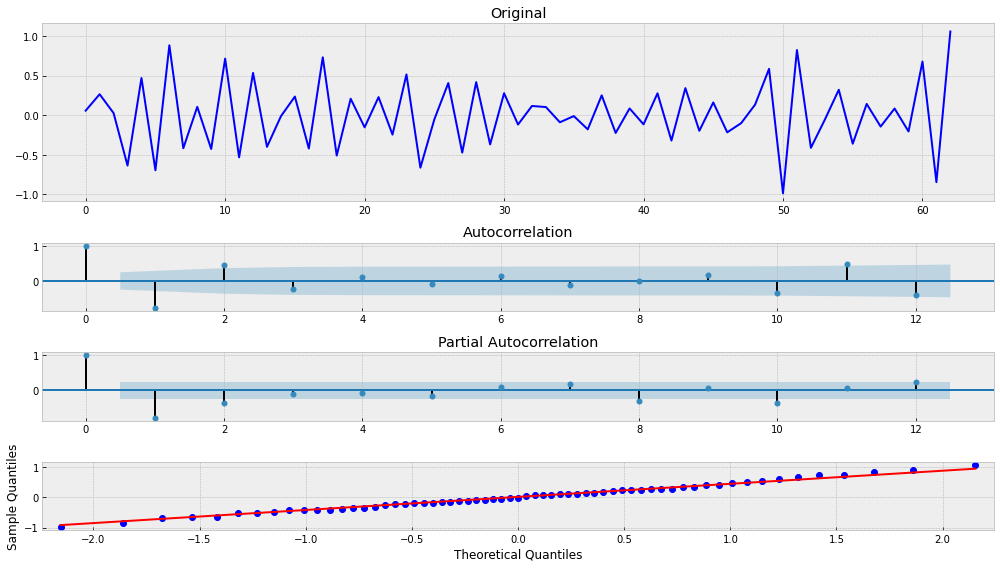

In [7]:
new_series = boxcox(series, 0)
new_series = new_series[12:] - new_series[:-12]
new_series =  np.diff(new_series,2)
tsplot(new_series, lags=12)

## ARIMA (p,d,q)


Возвращаемся к исходному выбранному ряду, он не стационарный p-value больше 0.05, есть сезонность и тренд, соответственно для моделирования ряда должна подойти модель ARIMA, так как в ней реализовано дифференциорование. Проверим какой уровень дифференцирования покажет модель с лучшим критерием AIC.  При самом наименьшем aic 
- aic: 858.17298 | order: (3, 1, 2) | DF test p-value: 0.27577

тест Дики Фулера на стационарность остатков не давал самого лучшего значения, добавляю сразу к оценки модели - расчет p-value, в этом случае наилучшими парметрами становится 
- aic: 888.36403 | order: (5, 1, 0) | DF test p-value: 0.00181


aic: 1050.71026 | order: (0, 0, 1) | DF test p-value: 0.99544
aic: 958.68721 | order: (0, 0, 3) | DF test p-value: 0.98605
aic: 913.87555 | order: (0, 1, 1) | DF test p-value: 0.07519
aic: 903.29759 | order: (0, 1, 2) | DF test p-value: 0.00000
aic: 903.53485 | order: (0, 1, 3) | DF test p-value: 0.00000
aic: 900.84468 | order: (0, 1, 4) | DF test p-value: 0.52158
aic: 887.65081 | order: (0, 1, 5) | DF test p-value: 0.44045
aic: 914.78933 | order: (0, 2, 1) | DF test p-value: 0.00000
aic: 913.51258 | order: (0, 2, 2) | DF test p-value: 0.00000
aic: 897.84167 | order: (0, 2, 3) | DF test p-value: 0.00000
aic: 897.82238 | order: (0, 2, 4) | DF test p-value: 0.00000
aic: 930.97164 | order: (1, 0, 0) | DF test p-value: 0.65652
aic: 927.88961 | order: (1, 0, 1) | DF test p-value: 0.75422
aic: 916.29263 | order: (1, 0, 2) | DF test p-value: 0.70429
aic: 911.12077 | order: (1, 1, 0) | DF test p-value: 0.03562
aic: 913.16653 | order: (1, 1, 2) | DF test p-value: 0.65760
aic: 899.72537 | order:

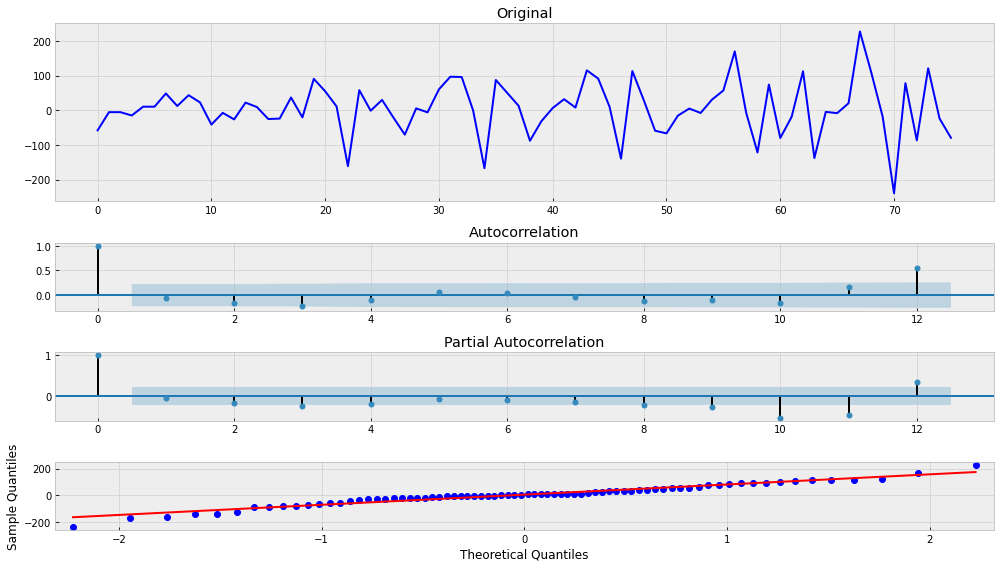

In [8]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(6):   # скользящее окно по предыдущим значениям
    for d in range(3):   # порядок дифференцирования
        for j in range(6):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                pv = test_stationarity(tmp_mdl.resid,1)
                print('aic: {:6.5f} | order: {} | DF test p-value: {:6.5f}'.format(tmp_aic, (i, d, j),pv))
                
                #print("DF test p-value: ", pv)
                if tmp_aic < best_aic and pv < 0.05:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
                    
            except: continue


print('best aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=12)

Остатки почти нормально распределены. Небольшой выброс в автокорреляции есть, но в принципе видим практически отсутствие корреляции остатков с предыдущими значениями самих себя. В целом модель подобрана удовлетворительно, попробуем для прогноза использовать. И еще раз для сравненния  посмотрим на остатки модели с наименьшим AIC

Results of Dickey-Fuller Test:
Test Statistic                 -2.024882
p-value                         0.275771
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


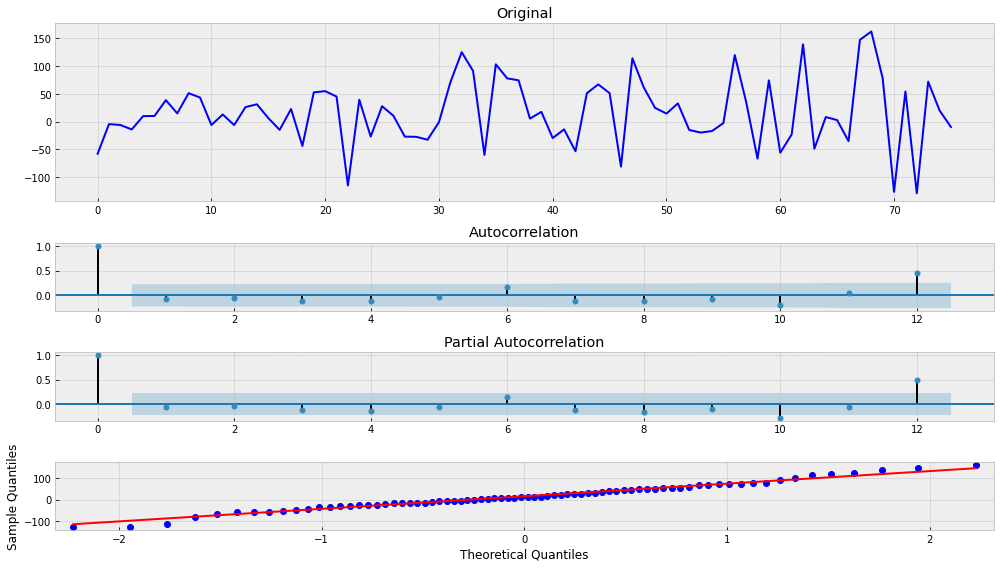

In [9]:
predictions = best_mdl.predict(1, len(series), typ = 'levels')

best_mdl2 = smt.ARIMA(series, order=(3,1,2)).fit(method='mle', trend='nc')


tsplot(best_mdl2.resid, lags=12)

Построим прогноз для сравнения по двум моделям.

##### aic: 888.36403 | order: (5, 1, 0) | DF test p-value: 0.00181

MSE:  3687.9802539276616
RMSE:  60.72874322697335


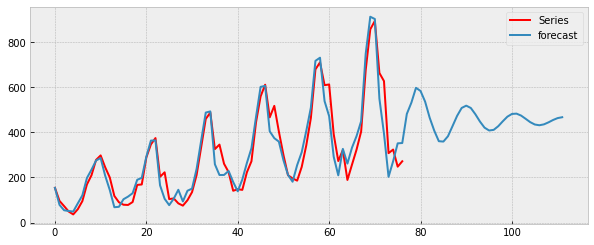

In [10]:
from statsmodels.tools.eval_measures import rmse 

print("MSE: ",mean_squared_error(series, predictions))
print("RMSE: ", rmse(series, predictions))

forecast = best_mdl.predict(start = 1,  
                          end = (len(series)-1) + 3 * 12,  
                          typ = 'levels')

with plt.style.context('bmh'):
    plt.figure(figsize=(10,4))
    ax = plt.axes()

    plt.plot(series, color='red', label='Series')
    plt.plot(forecast, label='forecast')
    plt.legend()
    plt.show()

#####  aic: 858.17298 | order: (3, 1, 2) | DF test p-value: 0.27577

MSE:  5877.638148533274
RMSE:  76.66575603575089


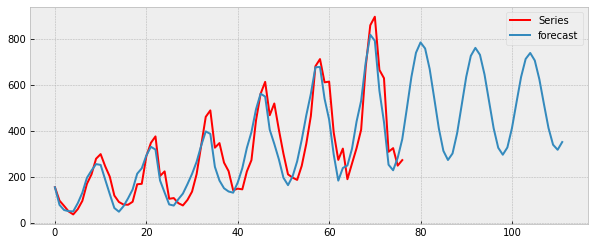

In [11]:

predictions2 = best_mdl2.predict(1, len(series), typ = 'levels')

from statsmodels.tools.eval_measures import rmse 

print("MSE: ",mean_squared_error(series, predictions2))
print("RMSE: ", rmse(series, predictions2))

forecast2 = best_mdl2.predict(start = 1,  
                          end = (len(series)-1) + 3 * 12,  
                          typ = 'levels')

with plt.style.context('bmh'):
    plt.figure(figsize=(10,4))
    ax = plt.axes()

    plt.plot(series, color='red', label='Series')
    plt.plot(forecast2, label='forecast')
    plt.legend()
    plt.show()

Остатки почти нормально распределены. Небольшой выброс в автокорреляции есть, но в принципе видем практически отсутствие корреляции остатков с предыдущими занчениями самих себя.  В целом модель подобрана удовлетворительно, можно использовать для прогнозирования

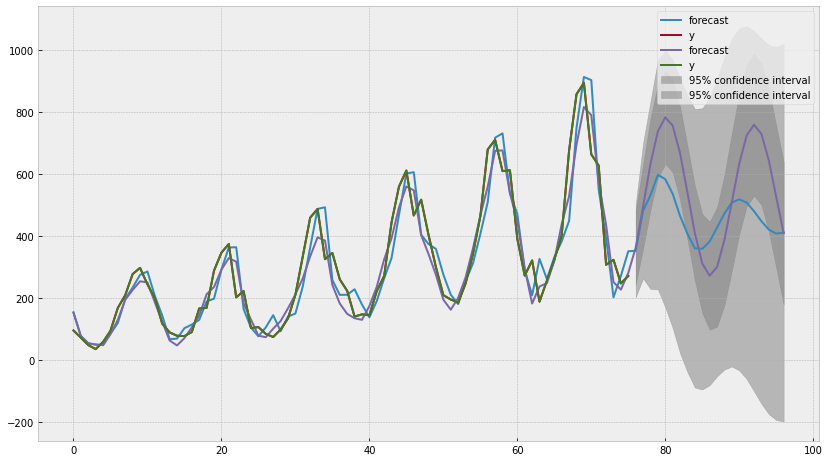

In [12]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(series)+20, ax=ax)
    best_mdl2.plot_predict(1, len(series)+20, ax=ax)

    plt.legend()
    plt.show()

In [13]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl



Используем  GARCH, 
так как GARCH сезонность и тренд не моделирут, выполним вручную

In [14]:
new_series = series
new_series = new_series[12:] - new_series[:-12]
new_series = new_series[1:] - new_series[:-1]

In [15]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 5  # окно авторегресси
o_ = 1  # для отрицательного значения ряда
q_ = 0  # скользящее окно по условным дисперсиям

# Using student T distribution usually provides better fit
am = arch_model(new_series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     59,   Neg. LLF: 349.0023559539757
Iteration:     10,   Func. Count:    116,   Neg. LLF: 348.91888954523165
Iteration:     15,   Func. Count:    171,   Neg. LLF: 348.8854218619862
Iteration:     20,   Func. Count:    226,   Neg. LLF: 348.85050691621217
Iteration:     25,   Func. Count:    281,   Neg. LLF: 348.7268688323622
Iteration:     30,   Func. Count:    337,   Neg. LLF: 348.67445737597035
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 348.6717942875081
            Iterations: 32
            Function evaluations: 371
            Gradient evaluations: 32
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -348.672
Distribution: 

В авторегресси больше значение дает 3 и 4 предыдущее значение. Остатки немного хуже и автокорреляция ухудшилась

Results of Dickey-Fuller Test:
Test Statistic                 -2.633180
p-value                         0.086332
#Lags Used                     10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


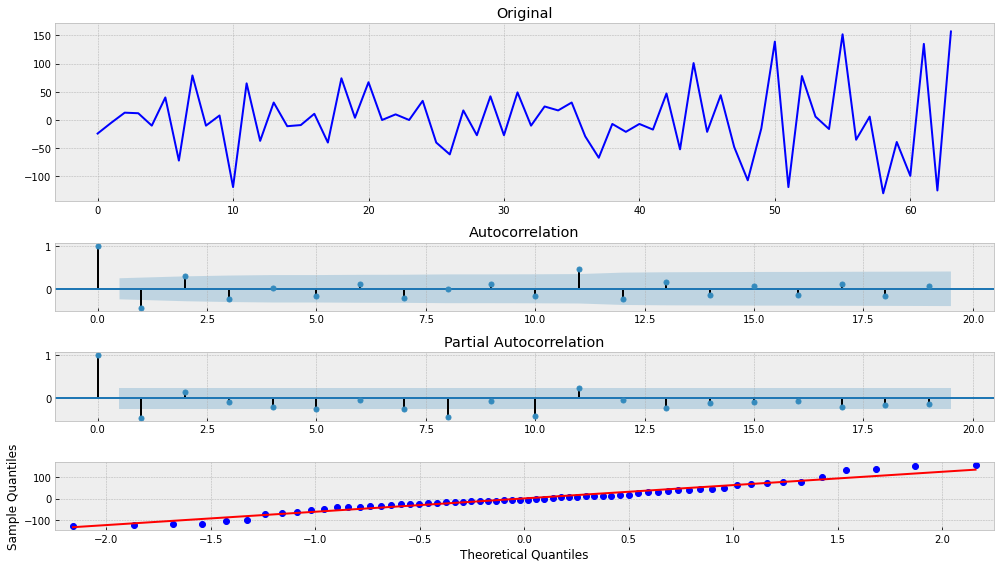

In [16]:
tsplot(res.resid)

Для другой модели 

In [17]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 3  # окно авторегресси
o_ = 1  # для отрицательного значения ряда
q_ = 2  # скользящее окно по условным дисперсиям

# Using student T distribution usually provides better fit
am2 = arch_model(new_series, p=p_, o=o_, q=q_, dist='StudentsT')
res2 = am2.fit(update_freq=5)
print(res2.summary())

Iteration:      5,   Func. Count:     57,   Neg. LLF: 347.6808904216422
Iteration:     10,   Func. Count:    114,   Neg. LLF: 347.4985846562707
Iteration:     15,   Func. Count:    169,   Neg. LLF: 347.42969661783843
Iteration:     20,   Func. Count:    224,   Neg. LLF: 347.12526632855577
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 347.03215850209864
            Iterations: 24
            Function evaluations: 279
            Gradient evaluations: 24
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                        GJR-GARCH   Log-Likelihood:               -347.032
Distribution:      Standardized Student's t   AIC:                           712.064
Method:                  Maximum Likelihood   BIC:                       

Results of Dickey-Fuller Test:
Test Statistic                 -2.633180
p-value                         0.086332
#Lags Used                     10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


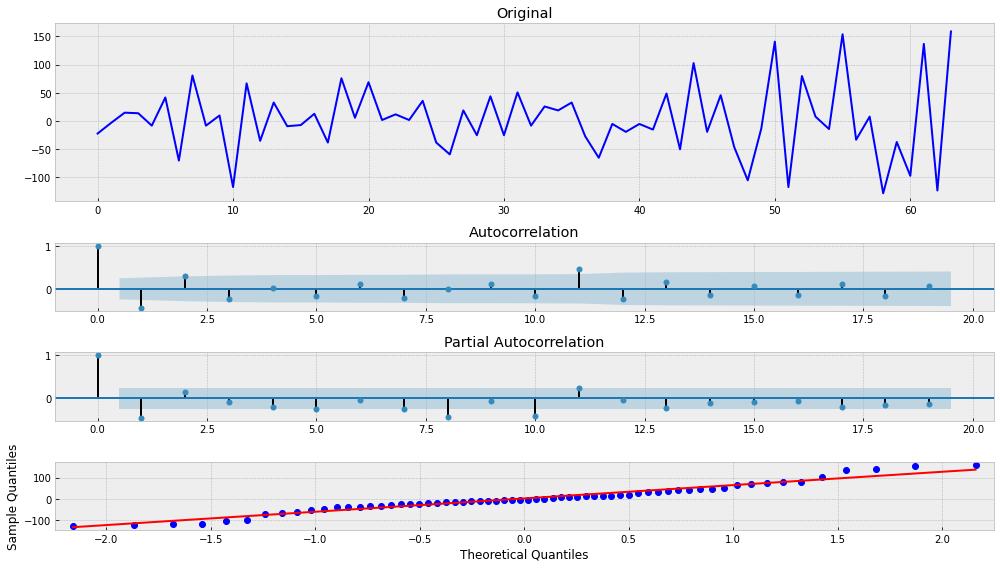

In [18]:
tsplot(res2.resid)

Две сравниваемые модели дают сопоставимые занчения остатков после применения GARCH

In [19]:
forecasts = res.forecast(horizon=3, start=1, method='simulation')
forecasts2 = res2.forecast(horizon=3, start=1, method='simulation')


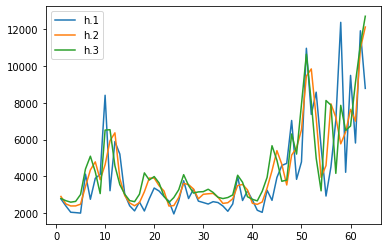

In [20]:
forecasts.variance[1:].plot()

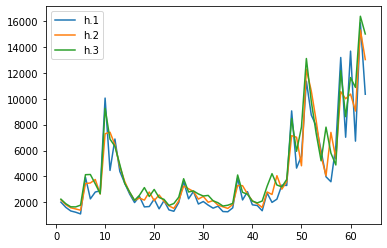

In [21]:
forecasts2.variance[1:].plot()

## С помощью ML методов

Сравним линейную регрессию и случайный лес. 

Генерируем большое количество фичей для нашего временного ряда -  добавим несколько признаков как предыдущие n значений с учетом веса, чем ближе к наблюдению текущему тем больше вес 

In [22]:
series = pd.read_csv("data/TimeSeries/monthly-sales-of-company-x-jan-6.csv")

In [23]:
def prepareData(data, lag_start=1, lag_end=12, test_size=0.3):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков логарифмируем и добаляем вес -чем ближе тем больше влияние
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = np.log(data.Count.shift(i)/i) #data.Count.shift(i)
   
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=12, test_size=0.3)

LinearRegression
MSE:  15245.421819847395
SQ MSE:  123.47235245125685
Score:  0.7256394222929781
RandomForest
MSE:  9826.76923076923
SQ MSE:  99.13006219492264
Score:  0.07692307692307693


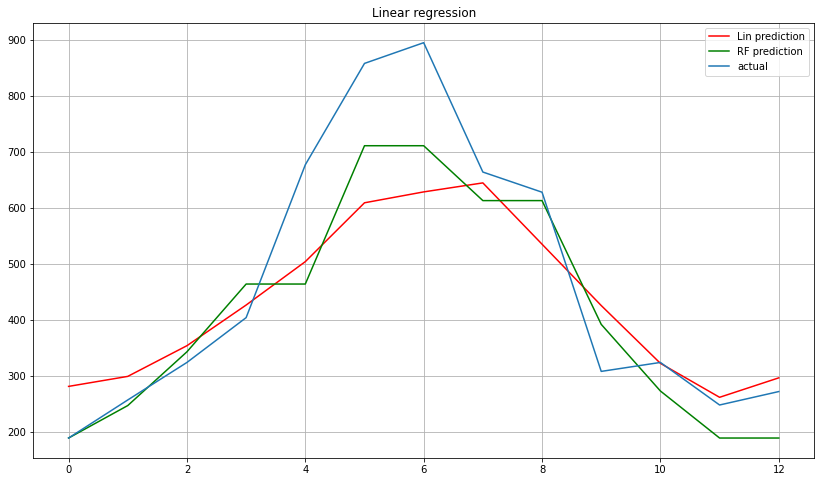

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

clf_rf = RandomForestClassifier(n_estimators=30, max_depth=20, min_samples_leaf=4, max_features=.6, n_jobs=-1)
clf_rf.fit(X_train, y_train)   
prediction2 = clf_rf.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="Lin prediction")
plt.plot(prediction2, "g", label="RF prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

score_ln1 = lr.score(X_test, y_test)
mse_ln1 = mean_squared_error(y_test, prediction)
sqrt_mse_ln1 = np.sqrt(mse_ln1)
print("LinearRegression")
print("MSE: ", mse_ln1)
print("SQ MSE: ", sqrt_mse_ln1)
print("Score: ", score_ln1)

score_rf = clf_rf.score(X_test, y_test)
mse_rf2 = mean_squared_error(y_test, prediction2)
sqrt_mse_rf2 = np.sqrt(mse_rf2)
print("RandomForest")
print("MSE: ", mse_rf2)
print("SQ MSE: ", sqrt_mse_rf2)
print("Score: ", score_rf)